## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [1]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
import numpy as np
from sklearn.metrics import accuracy_score

def gini(sequence):
    _, c = np.unique(sequence, return_counts=True)
    p = c / sequence.size
    return 1 - np.sum(p ** 2)


def entropy(sequence):
    _, c = np.unique(sequence, return_counts=True)
    p = c / sequence.size
    return -np.sum(p * np.log2(p))


class Criteria:
    @staticmethod
    def gini(y_data, mask):
        a = y_data[mask]
        b = y_data[~mask]
        return (gini(a) * a.size + gini(b) * b.size) / y_data.size

    @staticmethod
    def entropy(y_data, mask):
        a = y_data[mask]
        b = y_data[~mask]
        return (entropy(a) * a.size + entropy(b) * b.size) / y_data.size

    @staticmethod
    def weighted_error(y_data, mask):
        a = y_data[mask]
        b = y_data[~mask]
        a_label = np.argmax(np.bincount(a))
        b_label = np.argmax(np.bincount(b))

        a_error = np.sum(a != a_label)
        b_error = np.sum(b != b_label)

        return a_error + b_error

In [2]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [3]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [4]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [5]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

# train_df.head()


x_train = train_df.drop(labels=["price_range"], axis="columns")
feature_names = x_train.columns.values
x_train = x_train.values
y_train = train_df['price_range'].values

x_test = val_df.drop(labels=["price_range"], axis="columns")
x_test = x_test.values
y_test = val_df['price_range'].values

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

(1200, 21)
(300, 21)
x_train: (1200, 20)
y_train: (1200,)
x_test: (300, 20)
y_test: (300,)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [6]:
class DecisionTree:
    def __init__(self, criterion='gini', max_depth=None, cur_depth=0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.cur_depth = cur_depth
        self.l_branch = None
        self.r_branch = None
        self.split_index = None
        self.target = None
        self.predict_data = None
        self.feature_list = np.ndarray((0, ), dtype=np.int32)

    def fit(self, x_data, y_data, n_features = None, bootstrap = None):
        if self.cur_depth == self.max_depth:
            self.set_label(y_data)
            return

        if n_features is not None:
            choices = np.random.choice(x_data.shape[1], size=n_features, replace=bootstrap)
            x_data_ = x_data[:, choices]
            l_x_, r_x_, l_y_, r_y_, split_index_, target = self.find_best_split(x_data_, y_data)
            if l_x_ is None or r_x_ is None:
                self.set_label(y_data)
                return
            split_index = choices[split_index_]
            mask = x_data.T[split_index] <= target
            l_x = x_data[mask]
            r_x = x_data[~mask]
            l_y = y_data[mask]
            r_y = y_data[~mask]
        else:
            l_x, r_x, l_y, r_y, split_index, target = self.find_best_split(x_data, y_data)
            if l_x is None or r_x is None:
                self.set_label(y_data)
                return

        self.l_branch = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, cur_depth=self.cur_depth+1)
        self.r_branch = DecisionTree(criterion=self.criterion, max_depth=self.max_depth, cur_depth=self.cur_depth+1)
        self.split_index = split_index
        self.target = target

        self.l_branch.fit(l_x, l_y, n_features, bootstrap)
        self.r_branch.fit(r_x, r_y, n_features, bootstrap)

        self.feature_list = np.append(self.feature_list, split_index)
        self.feature_list = np.append(self.feature_list, self.l_branch.feature_list)
        self.feature_list = np.append(self.feature_list, self.r_branch.feature_list)

        return

    def set_label(self, y_data):
        self.predict_data = np.argmax(np.bincount(y_data))
        return

    def predict(self, x_data):
        result = []
        for features in x_data:
            result.append(self.predict_(features))
        return np.asarray(result)

    def predict_(self, features):
        if self.predict_data is not None:
            return self.predict_data
        if features[self.split_index] <= self.target:
            return self.l_branch.predict_(features)
        else:
            return self.r_branch.predict_(features)

    def find_best_split(self, x_data, y_data):
        if np.unique(y_data).size == 1:
            return None, None, None, None, None, None
        criteria = getattr(Criteria, self.criterion)
        best_split_index = None
        best_split_target = None
        best_split_purity = 2
        for feature_index, feature in enumerate(x_data.T):
            values = np.unique(feature)
            for val in values:
                mask = feature <= val
                if mask.all() == True or mask.any() == False:
                    continue
                purity = criteria(y_data, mask)
                if purity <= best_split_purity:
                    best_split_purity = purity
                    best_split_target = val
                    best_split_index = feature_index

        if best_split_index is None:
            return None, None, None, None, None, None

        split_mask = x_data.T[best_split_index] <= best_split_target
        l_x = x_data[split_mask]
        r_x = x_data[~split_mask]
        l_y = y_data[split_mask]
        r_y = y_data[~split_mask]

        return l_x, r_x, l_y, r_y, best_split_index, best_split_target

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [7]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
print("clf_depth3: ", accuracy_score(y_test, clf_depth3.predict(x_test)))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
print("clf_depth10: ", accuracy_score(y_test, clf_depth10.predict(x_test)))

clf_depth3:  0.9166666666666666
clf_depth10:  0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [8]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
print("clf_gini: ", accuracy_score(y_test, clf_gini.predict(x_test)))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
print("clf_entropy: ", accuracy_score(y_test, clf_entropy.predict(x_test)))

clf_gini:  0.9166666666666666
clf_entropy:  0.93


- Note: Your decision tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

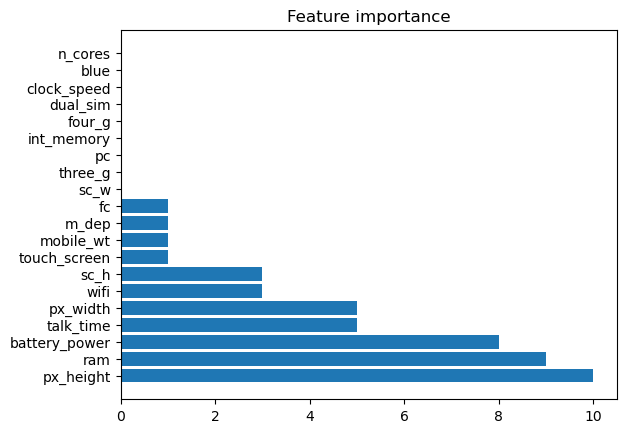

In [9]:
import matplotlib.pyplot as plt

feature_importance = np.bincount(clf_depth10.feature_list)
arg = np.argsort(feature_importance)
names = feature_names[arg]

plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(names.size)
importance = feature_importance[arg]

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos, labels=names)
ax.invert_yaxis()
ax.set_title('Feature importance')

plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [25]:
class AdaBoost:
    def __init__(self, n_estimators):
        self.estimators = []
        self.alp = np.ndarray((0, ), dtype=np.float32)
        self.n_estimators = n_estimators

    def fit(self, x_data, y_data):
        weights = np.ones_like(y_data) / y_data.size
        x_train_ = np.copy(x_data)
        y_train_ = np.copy(y_data)
        self.estimators = []
        self.alp = []
        for _ in range(self.n_estimators):
            clf_ = DecisionTree(max_depth=1, criterion='entropy')
            clf_.fit(x_train_, y_train_)

            pred = clf_.predict(x_data)
            mask = pred != y_data
            eps = np.sum(weights[mask])
            alp = 0.5 * np.log((1.0 - eps) / eps)

            self.estimators.append(clf_)
            self.alp.append(alp)

            sig = np.ones_like(weights)
            sig[mask] = -1

            weights *= np.exp(-alp * sig)
            weights /= np.sum(weights)
            samples = np.random.choice(range(0, y_data.size), p=weights, size=y_data.size)

            x_train_ = x_data[samples]
            y_train_ = y_data[samples]


    def predict(self, x_data):
        pred = [clf_.predict(x_data) for clf_ in self.estimators]
        pred = np.asarray(pred).T
        res = [np.argmax(np.bincount(p, weights=self.alp)) for p in pred]
        return np.asarray(res)

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [11]:
clf_adaboost10 = AdaBoost(n_estimators=10)
clf_adaboost10.fit(x_train, y_train)
print("clf_adaboost10: ", accuracy_score(y_test, clf_adaboost10.predict(x_test)))

clf_adaboost100 = AdaBoost(n_estimators=100)
clf_adaboost100.fit(x_train, y_train)
print("clf_adaboost100: ", accuracy_score(y_test, clf_adaboost100.predict(x_test)))

clf_adaboost10:  0.94
clf_adaboost100:  0.9666666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [12]:
class RandomForest:
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.estimators = []
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth

    def fit(self, x_data, y_data):
        self.estimators = []
        for _ in range(self.n_estimators):
            clf_ = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
            clf_.fit(x_data, y_data, n_features=self.max_features, bootstrap=self.boostrap)
            self.estimators.append(clf_)

    def predict(self, x_data):
        pred = [clf_.predict(x_data) for clf_ in self.estimators]
        pred = np.asarray(pred).T
        res = [np.argmax(np.bincount(p)) for p in pred]
        return np.asarray(res)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [13]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
print("clf_10tree: ", accuracy_score(y_test, clf_10tree.predict(x_test)))

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
print("clf_100tree: ", accuracy_score(y_test, clf_100tree.predict(x_test)))

clf_10tree:  0.94
clf_100tree:  0.9366666666666666


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [14]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train, y_train)
print("clf_random_features: ", accuracy_score(y_test, clf_random_features.predict(x_test)))

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
print("clf_all_features: ", accuracy_score(y_test, clf_all_features.predict(x_test)))

clf_random_features:  0.95
clf_all_features:  0.95


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [26]:
def train_your_model(data_):
    ## Define your model and training
    x_train_ = data_.drop(labels=["price_range"], axis="columns")
    x_train_ = x_train_.values
    y_train_ = train_df['price_range'].values
    clf_ = AdaBoost(n_estimators=100)
    clf_.fit(x_train_, y_train_)
    return clf_

In [27]:
my_model = train_your_model(train_df)

In [28]:
y_pred = my_model.predict(x_test)

In [29]:
assert y_pred.shape == (500, )

AssertionError: 

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [123]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
